In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
import preprocess, sweep_utils
from plotting_utils import figSize, setTickLabels
from lineplots import plotsd
from session_utils import *
from recalibration_utils import *
from click_utils import *


pearson_r_thresh = 0.15**0.5
SWEEP_DIR        = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/T5/HMM/HMMsweep/'
fig_path         = '/home/users/ghwilson/projects/nonstationarities/figures/'
params           = ['kappa', 'inflection', 'exp']
fields           = ['R2_score', 'meanrecal_pearson_r', 'pearson_r', 'days_apart', 'viterbi_prob', 'file']
int_encode_files = True
prune            = None


# load files and check if any are missing:
files    = glob.glob(SWEEP_DIR + '*scores_ID*') 
file_IDs = [int(x.split('ID_')[1].split('.npy')[0]) for x in files]
maxval   = np.max(file_IDs)
diff     = np.setdiff1d(np.arange(maxval + 1), file_IDs)

if len(diff) > 0:
    raise ValueError('Missing sweeps: ', diff)

scores_df = sweep_utils.getSummaryDataFrame(files, params + fields, prune = prune, int_encode_files = int_encode_files)
scores_df = scores_df[scores_df['meanrecal_pearson_r'] > pearson_r_thresh]

scores_df['viterbi_prob'] = scores_df['viterbi_prob'].apply(lambda x: x[0] )
print('Done loading')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done loading


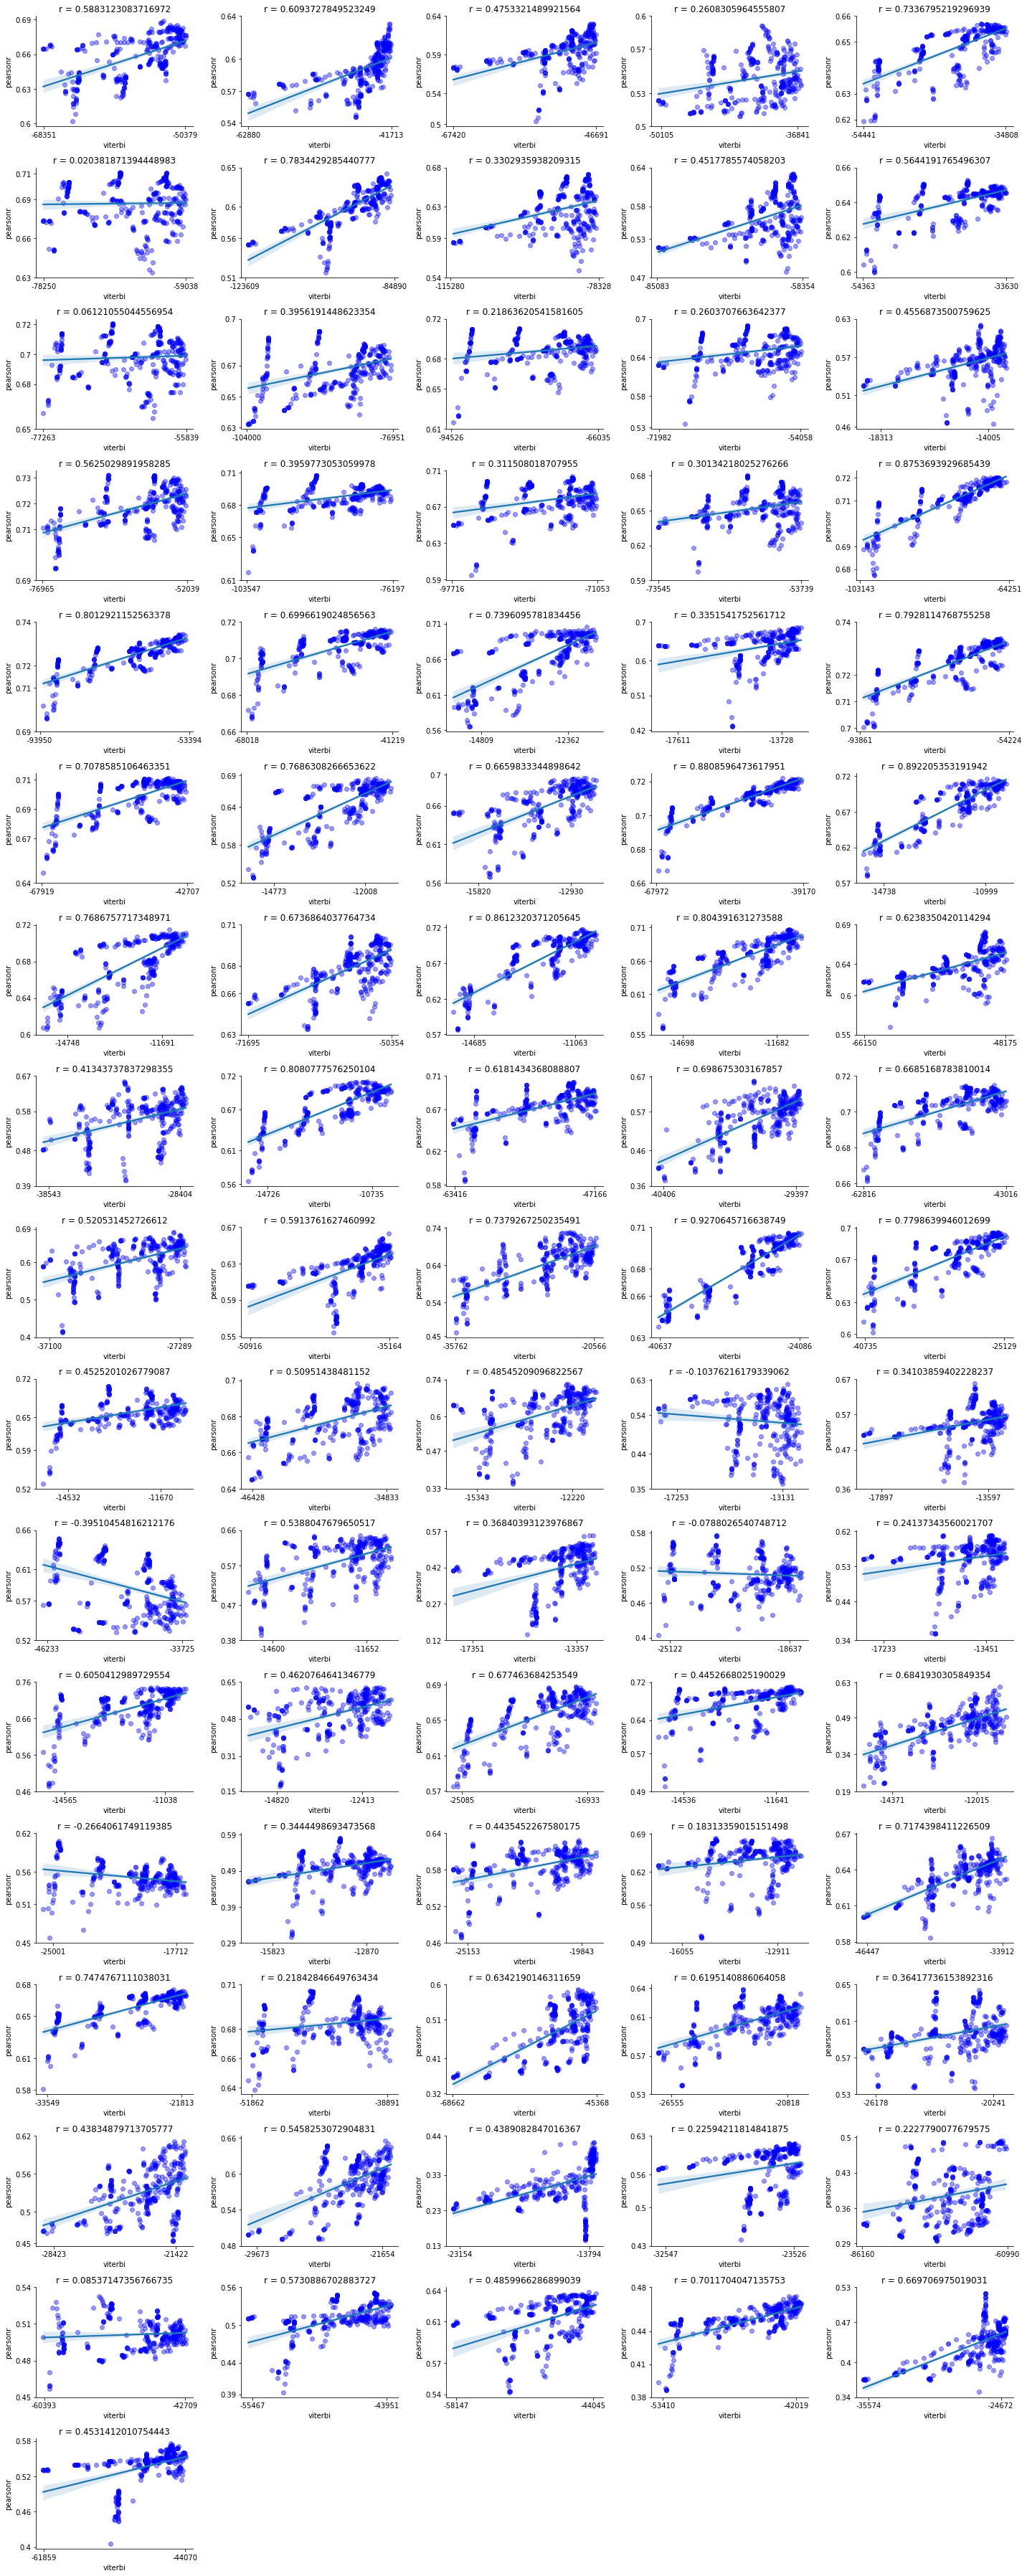

In [3]:
figSize(50, 20)

plt.locator_params(nbins=4)

n_cols = 5

unique           = np.unique(scores_df['file'])
autotune_pearson = np.zeros(len(unique))
grpopt_pearson   = np.zeros(len(unique))
corrs            = np.zeros(len(unique))
n_rows           = np.ceil(len(unique) / n_cols).astype(int)

for i, val in enumerate(unique):
    
    # subselect parameter sweeps for a given session pair, extract viterbi and pearson r 
    subset_idxs = scores_df['file'].apply(lambda x: x == val)
    subset      = scores_df[subset_idxs]
    viterbi     = subset['viterbi_prob'].to_numpy()
    pearsonr    = subset['pearson_r'].to_numpy()
    
    corr     = np.corrcoef(viterbi, pearsonr)[0, 1]
    corrs[i] = corr
    
    # grab autotuned score
    max_viterbi_idx     = np.argmax(viterbi)
    autotune_pearson[i] = pearsonr[max_viterbi_idx]
    
    # grab score from optimal hyperparameters based on group mean
    opt         = {'kappa' : 2, 'inflection' : 70, 'exp' : 0.5}
    subset_df   = sweep_utils.get_subsetDF(subset, opt)
    pearson_grp_opt   = subset_df['pearson_r']
    grpopt_pearson[i] = pearson_grp_opt
    
    plt.subplot(n_rows, n_cols, i + 1)
    ax = plt.gca()
        
    lm_df = pd.DataFrame({'viterbi' : viterbi, 'pearsonr' : pearsonr})
    sns.regplot(x = 'viterbi', y = 'pearsonr', data = lm_df, 
               scatter_kws = {'alpha' : 0.4, 'color' : 'b'}, ax = ax)
    plt.title(f'r = {corr}')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ymin, ymax = ax.get_ylim()
    custom_ticks = np.round(np.linspace(ymin, ymax, 4), 2)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticks)
   
    xmin, xmax = ax.get_xlim()
    custom_ticks = np.linspace(xmin + 1000, xmax - 1000, 2, dtype = int)
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticks)
        
plt.tight_layout()

#plt.savefig(fig_path + 'HMM/viterbi_vs_pearson', format = 'pdf')
plt.show()

/home/users/ghwilson/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/users/ghwilson/.local/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


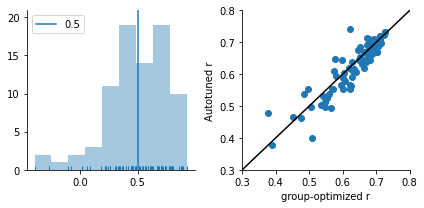

In [4]:
import seaborn as sns
figSize(3, 6)

plt.subplot(1, 2, 1)

#sns.set_theme()

plt.style.use('default')

sns.distplot(corrs, rug = True, kde = False, )
mean_corr = np.mean(corrs)
plt.axvline(mean_corr, label = np.round(mean_corr, 3))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()

plt.subplot(1, 2, 2)
lims = [0.3, 0.8]
plt.scatter(grpopt_pearson, autotune_pearson)
plt.xlabel('group-optimized r')
plt.ylabel('Autotuned r')
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, c = 'k')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
#plt.savefig(fig_path + 'HMM/viterbi_vs_pearson_summary', format = 'pdf')
plt.show()

In [41]:
import resample 

unique_idxs      = np.unique(scores_df['file'], return_index=True)[1]
unique_scores_df = scores_df[['file', 'days_apart']].iloc[unique_idxs]

#graph, idxs = resample.makeSessionPairGraph(unique_scores_df, int_encoded = True)
#x           = idxs[resample.graphSets(graph)]
x = np.array([ 0,  9, 19, 28, 36, 42, 45, 55, 62, 64, 67, 71, 72, 76, 78, 79])

print('Wilcoxon test of group and automated testing:')
print(scipy.stats.wilcoxon(grpopt_pearson[x], autotune_pearson[x]))
print('Diff (mean +- SD):', np.mean(grpopt_pearson[x] - autotune_pearson[x]), np.std(grpopt_pearson[x] - autotune_pearson[x]))

Wilcoxon test of group and automated testing:
WilcoxonResult(statistic=43.0, pvalue=0.19610818609418723)
Diff (mean +- SD): -0.015554190414672653 0.035733935211430694


Now compare against random picking

In [29]:
n_shuffles = 1000 #000

autotune_pearson_null = np.zeros((len(x), n_shuffles))
for i, val in enumerate(unique[x]):
    subset_idxs = scores_df['file'].apply(lambda x: x == val)
    subset      = scores_df[subset_idxs]
    pearsonr    = subset['pearson_r'].to_numpy()
    
    pearson_null = np.random.choice(pearsonr, n_shuffles, replace = True)
    autotune_pearson_null[i, :] = pearson_null


/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


p= 0.001


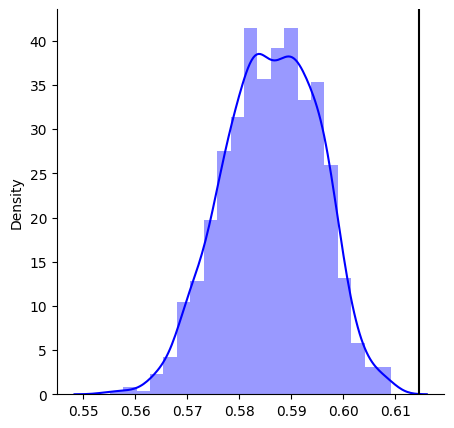

In [45]:
figSize(5, 5)

orig_mean  = np.mean(autotune_pearson[x])
null_means = np.mean(autotune_pearson_null, axis = 0)

sns.distplot(null_means, color = 'b')

print('p=', (sum(null_means > orig_mean) + 1) / len(null_means))

plt.axvline(orig_mean, color = 'k')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(fig_path + 'HMM/viterbi_vs_pearson_null', format = 'pdf')
plt.show()